<a href="https://colab.research.google.com/github/covidba/covid/blob/master/covid19_bahia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evolução da COVID-19 na Bahia
**Fonte**: http://www.saude.ba.gov.br/temasdesaude/coronavirus/notas-tecnicas-e-boletins-epidemiologicos-covid-19/  
**Dados crus**: https://raw.githubusercontent.com/covidba/covid/master/bahia.csv   
**Github**: https://github.com/covidba/covid

In [1]:
cidade = 'Bahia'
cidade_file_name = 'bahia'
populacao =  14873064
 
import sys
from google.colab import drive
drive.mount('/content/gdrive')
 
#!cd gdrive/My\ Drive && git clone https://github.com/ramonfontes/Mathematical-and-Statistical-Modeling-of-COVID19-in-Brazil/ model
!pip install platypus-opt
!pip install pyswarms==1.1.0
 
#add the path were the models are
sys.path.append("/content/gdrive/My Drive/model/main/")
 
from modelos import SIR

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
     |████████████████████████████████| 71kB 4.9MB/s 
     |████████████████████████████████| 102kB 5.6MB/s 


In [0]:
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import numpy as np
 
data_atual = date.today().strftime("%d-%m-%Y")
url = 'https://raw.githubusercontent.com/covidba/covid/master/%s.csv' % cidade_file_name
df = pd.read_csv(url, usecols=['data', 'confirmados','recuperados', 'mortes']) #, parse_dates=['data'])
df.columns = ['data', 'Casos confirmados', 'Casos recuperados', 'Mortes']
df['data'] = pd.to_datetime(df['data'])

In [3]:
#Start the model with population size
model = SIR(tamanhoPop = populacao)
#create a series with the cummulative number of cases
y = df["Casos confirmados"]
#Give the number of days since the day of first case confirmed
x = range(1,len(df["Casos confirmados"]) + 1)
model.fit(x = x, y = y)
#Predict the number of cases
df["Expectativa"] = model.predict(x)

2020-05-29 22:58:31,949 - pyswarms.single.local_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 1}
pyswarms.single.local_best:   0%|          |0/500/content/gdrive/My Drive/model/main/modelos.py:156: RuntimeWarning: overflow encountered in exp
  h = 1.0/(1.0+ np.exp(-2.0*50*t))
pyswarms.single.local_best: 100%|██████████|500/500, best_cost=11
2020-05-29 23:00:38,706 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 11.044958509817903, best pos: [ 0.1892258   0.12278557  0.1811229  19.04169229]


In [5]:
#Projections about the future
futherCases = pd.DataFrame.from_dict({"data":pd.date_range(start = df['data'].max()+timedelta(days=1) , end = df['data'].max()+timedelta(days=7))})

df_proj = pd.concat([df,futherCases])
#create the new series to be predicted
predictions = model.predict(df_proj)

/content/gdrive/My Drive/model/main/modelos.py:156: RuntimeWarning: overflow encountered in exp
  h = 1.0/(1.0+ np.exp(-2.0*50*t))


2020-05-29 23:01:55,465 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.


,data,Casos confirmados,Casos recuperados,Mortes,Expectativa,Casos ativos,Casos ativos (%)
43,2020-05-09,5174,1337,196,5134.560175,3837,74.2
44,2020-05-10,5558,1391,202,5463.154453,4167,75.0
45,2020-05-11,5558,1391,202,5811.438430,4167,75.0
46,2020-05-12,6204,1644,225,6180.622910,4560,73.5
47,2020-05-13,6547,1790,236,6571.954611,4757,72.7
48,2020-05-14,6955,1963,262,6986.749532,4992,71.8
49,2020-05-15,8128,1963,281,7426.398635,6165,75.8
50,2020-05-16,8314,2151,286,7892.380325,6163,74.1
51,2020-05-17,8443,2199,295,8386.284999,6244,74.0
52,2020-05-18,8581,2407,312,8909.785863,6174,71.9


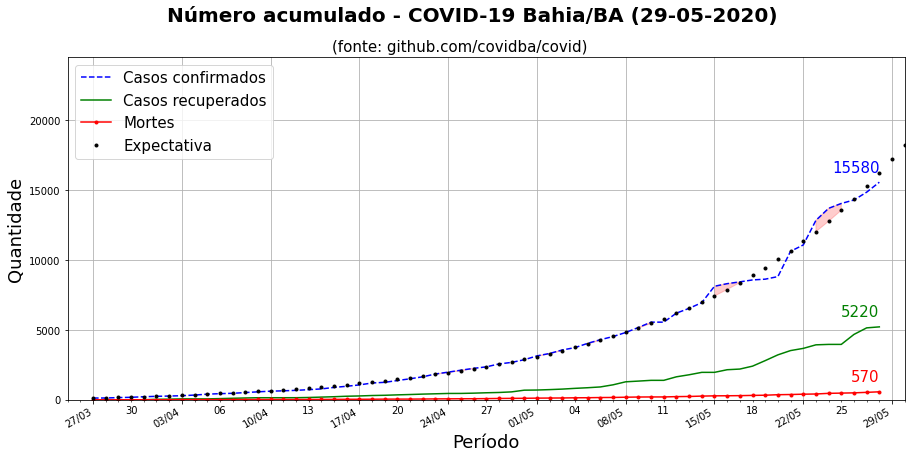

In [6]:
from matplotlib.dates import MO

casos_ativos_diaria = []
for i, v in enumerate(df['Casos confirmados']):
  casos_ativos_diaria.append(v - df['Casos recuperados'][i])
df['Casos ativos'] = casos_ativos_diaria

percentual_casos_ativos_diaria = []
for i, v in enumerate(df['Casos confirmados']):
  percentual_casos_ativos_diaria.append('%.1f' % (df['Casos ativos'][i]*100/v))
df['Casos ativos (%)'] = percentual_casos_ativos_diaria

new_df = df.append(futherCases)
new_df.reset_index(inplace=True, drop=True)
new_df['Expectativa'] = predictions

#set date as index
lista_data = new_df['data']
new_df.set_index('data', inplace=True)

fig, ax = plt.subplots(figsize=(15,7))
colors = ['b','g','r', 'black']
ls = ['--', '-', '.-', '.']

df2 = new_df
del df2['Casos ativos']
df2.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))
#plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(df.index.to_series().dt.strftime("%d/%m")))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

# ADICIONAR VALORES
casos_confirmados_series = pd.DataFrame(df2['Casos confirmados'])
ultimo_caso_valido_id = casos_confirmados_series.index.get_loc(casos_confirmados_series.last_valid_index())
def adicionar_valores(caso, color, y=10):
  ax.annotate(int(df2[caso].max()), xy=(lista_data[ultimo_caso_valido_id], df2[caso].max()), 
              xycoords='data', ha='right', fontsize=15, color=color,
              xytext=(0, y), textcoords='offset points')
  
adicionar_valores('Casos confirmados', 'b')
adicionar_valores('Casos recuperados', 'g')
adicionar_valores('Mortes', 'r')
#adicionar_valores('Mortes', 'r')

casos_ativos = int(df2['Casos confirmados'].max() - df2['Casos recuperados'].max())
#taxa_mortalidade = (100 * df2['Mortes'].max()) / df2['Casos confirmados'].max()
url_fonte = 'github.com/covidba/covid'

ax.fill_between(new_df.index, new_df['Casos confirmados'], new_df['Expectativa'], 
                where=new_df['Casos confirmados']>=new_df['Expectativa'], alpha=0.2, color='red')

ax.set_ylim(0, new_df['Expectativa'].max())
ax.set_xlim([lista_data.min()-timedelta(days=2), lista_data.max()-timedelta(days=5)])
fig.suptitle("Número acumulado - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20, fontweight='bold')
ax.set_title("(fonte: %s)           " % url_fonte, fontsize=15)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)
df.tail(20)

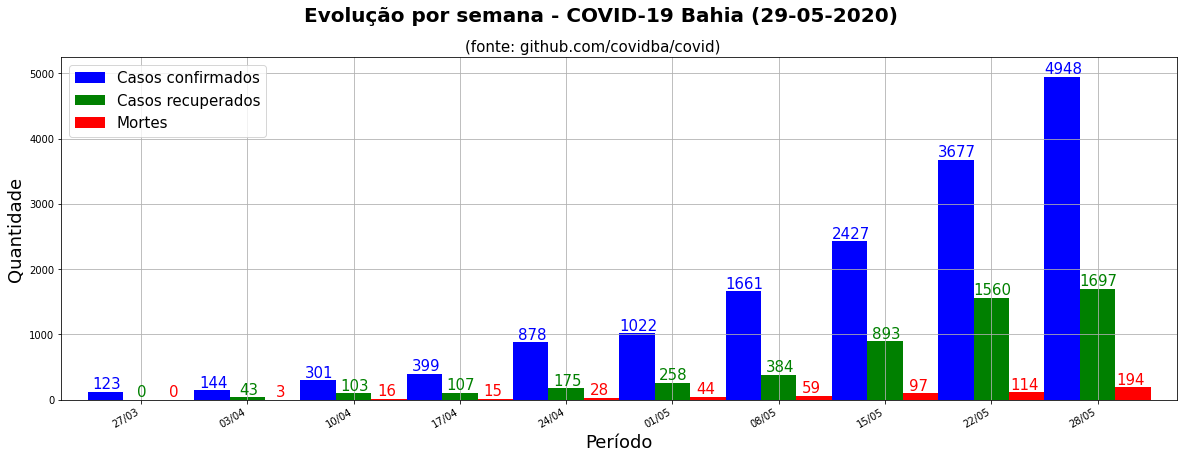

In [10]:
frequencia = 7
colors = ['b','g','r', 'orange']

dict_diaria = dict()
dict_diaria['data'] = []
dict_diaria['confirmados_diaria'] = []
dict_diaria['recuperados_diaria'] = []
dict_diaria['mortes_diaria'] = []

casos_confirmados_diaria = []
casos_recuperados_diaria = []
casos_mortes_diaria = []

def alimentar_lista(lista, texto):
  for id, v in enumerate(new_df[texto]):
    if not pd.isnull(v):
      if(id) == 0:
        lista.append(v)  
      else:
        lista.append(v - new_df[texto][id-1])
    elif id < len(lista_data)-7:
        lista.append(0)

alimentar_lista(casos_confirmados_diaria, 'Casos confirmados')
alimentar_lista(casos_recuperados_diaria, 'Casos recuperados')
alimentar_lista(casos_mortes_diaria, 'Mortes')

def alimentar_dict(lista, texto):
  soma_casos = 0
  for id, v in enumerate(lista):
    if not pd.isnull(v):
      if id % frequencia == 0:
        if texto == 'confirmados_diaria':
            dict_diaria['data'].append(lista_data[id])
        if id == 0:
          dict_diaria[texto].append(v)
        else:
          if(len(lista)-1 == id):
            dict_diaria[texto].append(soma_casos)
            dict_diaria[texto].append(v)
            if texto == 'confirmados_diaria':
              dict_diaria['data'].append(lista_data.max()+timedelta(days=1))
          else:
            dict_diaria[texto].append(soma_casos)
            soma_casos = v
      else:
        soma_casos += v
        if(len(lista)-1 == id):
          dict_diaria[texto].append(soma_casos)
          if texto == 'confirmados_diaria':
            dict_diaria['data'].append(lista_data[id])

alimentar_dict(casos_confirmados_diaria, 'confirmados_diaria')
alimentar_dict(casos_recuperados_diaria, 'recuperados_diaria')
alimentar_dict(casos_mortes_diaria, 'mortes_diaria')
#alimentar_dict(casos_ativos_diaria, 'ativos_diaria')

df_diaria = pd.DataFrame(dict_diaria)
df_diaria.columns = ['data', 'Casos confirmados', 'Casos recuperados', 'Mortes'] #, 'Casos ativos']
novo_df = df_diaria

df_diaria.set_index('data', inplace=True)
fig, ax = plt.subplots(figsize=(20,7))
df_diaria.plot(ax=ax, color=colors, kind='bar', width=1)
fig.autofmt_xdate()

# workaround para erro em bar kind
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(df_diaria.index.to_series().dt.strftime("%d/%m")))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

def plotar_valores(texto, cor, x):
  for i, v in enumerate(df_diaria[texto]):
    if not pd.isnull(v):
      ax.annotate(int(v), xy=(i, v), xycoords='data', ha='center', fontsize=15, color=cor,
                xytext=(x, 3), textcoords='offset points')

plotar_valores('Casos confirmados', 'b', -34)
plotar_valores('Casos recuperados', 'g', 1)
plotar_valores('Mortes', 'r', 33)


ax.set_ylim([0, df_diaria['Casos confirmados'].max() + 300])
fig.suptitle("Evolução por semana - COVID-19 %s (%s)" % (cidade, data_atual), fontsize=20, fontweight='bold')
ax.set_title("(fonte: %s)           " % url_fonte, fontsize=15)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)

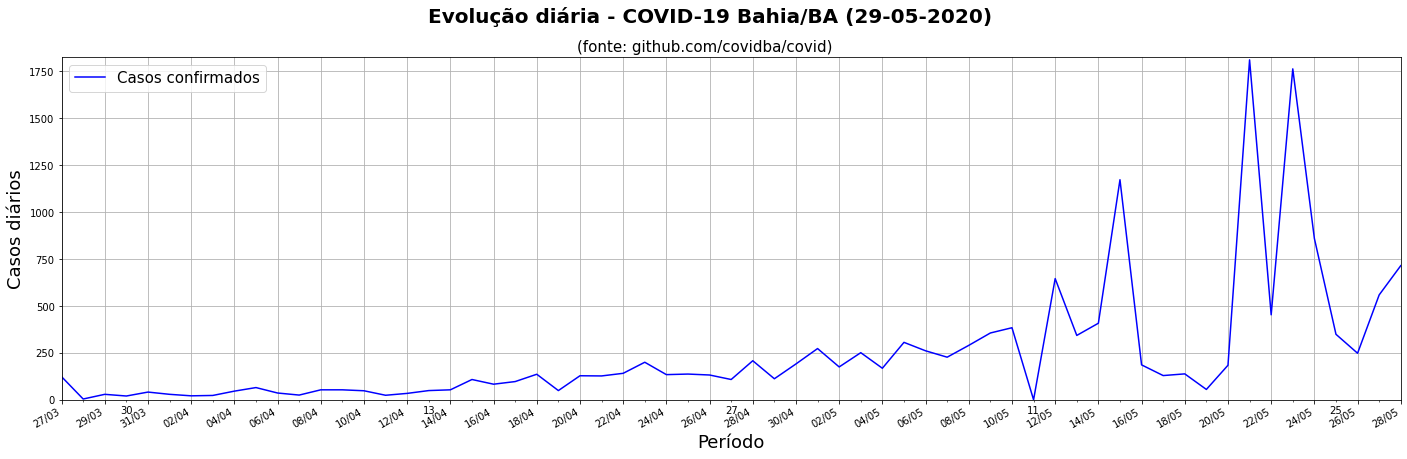

In [20]:
dict_diaria = dict()
dict_diaria['data'] = lista_data[:len(lista_data)-7]
dict_diaria['confirmados_diaria'] = casos_confirmados_diaria

df_diaria = pd.DataFrame(dict_diaria)
df_diaria.columns = ['data', 'Casos confirmados']
novo_df = df_diaria

df_diaria.set_index('data', inplace=True)
fig, ax = plt.subplots(figsize=(24,7))
df_diaria.plot(ax=ax, color=colors, kind='line')
fig.autofmt_xdate()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

ax.set_ylim([0, df_diaria['Casos confirmados'].max()+15])
ax.set_xlim([lista_data.min(), lista_data.max()-timedelta(days=7)])
fig.suptitle("Evolução diária - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20, fontweight='bold')
ax.set_title("(fonte: %s)           " % url_fonte, fontsize=15)
ax.set_ylabel('Casos diários', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)

plt.savefig('/content/gdrive/My Drive/%s-evolucao-diaria.png' % cidade_file_name)

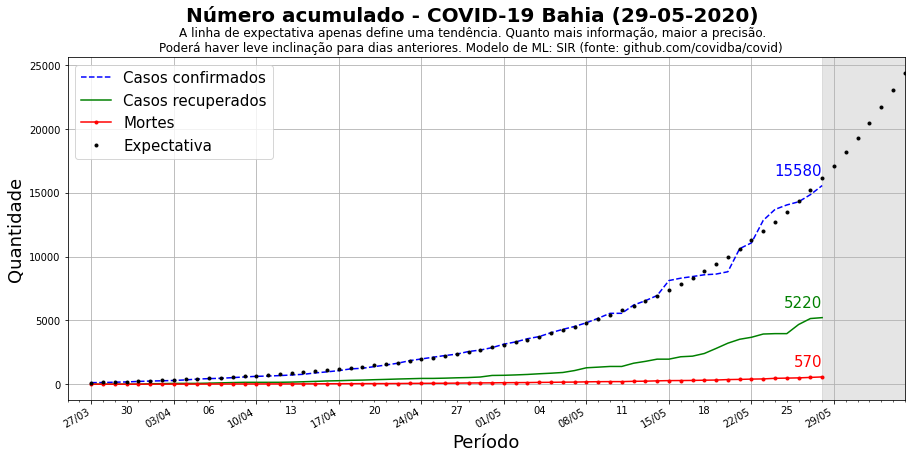

In [0]:
fig, ax = plt.subplots(figsize=(15,7))
colors = ['b','g','r', 'black']
ls = ['--', '-', '.-', '.']
new_df1 = new_df
if 'Casos ativos' in new_df1:
  del new_df1['Casos ativos']

new_df1.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

# pintar área de projeção
ax.axvspan(df['data'][ultimo_caso_valido_id].strftime("%Y-%m-%d"), lista_data.max().strftime("%Y-%m-%d"), 
           alpha=0.2, color='gray')

# ADICIONAR VALORES  
adicionar_valores('Casos confirmados', 'b')
adicionar_valores('Casos recuperados', 'g')
adicionar_valores('Mortes', 'r')

ax.set_xlim([lista_data.min()-timedelta(days=2), lista_data.max()])
fig.suptitle("Número acumulado - COVID-19 %s (%s)" % (cidade, data_atual), fontsize=20, fontweight='bold')
ax.set_title("A linha de expectativa apenas define uma tendência. Quanto mais informação, maior a precisão.       \nPoderá haver leve inclinação para dias anteriores. Modelo de ML: SIR (fonte: %s)        "  % url_fonte)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)
plt.savefig('/content/gdrive/My Drive/%s-geral.png' % cidade_file_name)

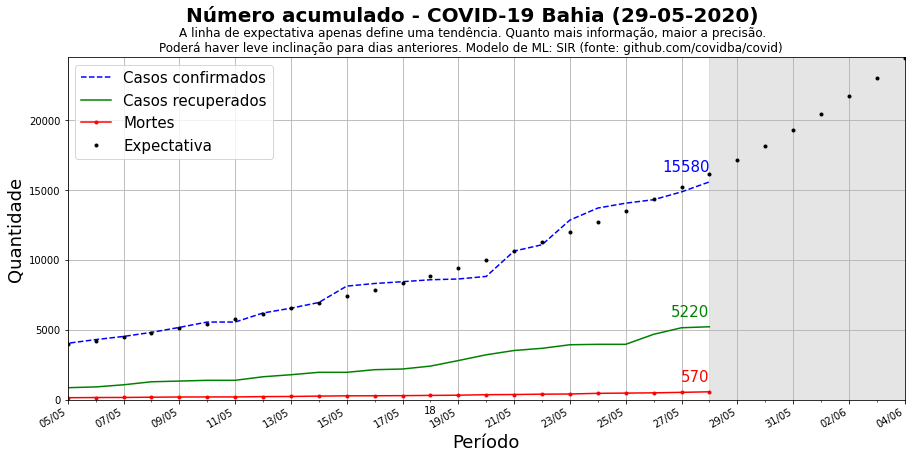

In [0]:
fig, ax = plt.subplots(figsize=(15,7))
new_df.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

# pintar área de projeção
ax.axvspan(df['data'][ultimo_caso_valido_id].strftime("%Y-%m-%d"), lista_data.max().strftime("%Y-%m-%d"), 
           alpha=0.2, color='gray')

# ADICIONAR VALORES
adicionar_valores('Casos confirmados', 'b')
adicionar_valores('Casos recuperados', 'g')
adicionar_valores('Mortes', 'r')

ax.set_ylim([0, new_df['Expectativa'].max() + 70])
ax.set_xlim([lista_data.max() - timedelta(days=30), lista_data.max()])
fig.suptitle("Número acumulado - COVID-19 %s (%s)" % (cidade, data_atual), fontsize=20, fontweight='bold')
ax.set_title("A linha de expectativa apenas define uma tendência. Quanto mais informação, maior a precisão.       \nPoderá haver leve inclinação para dias anteriores. Modelo de ML: SIR (fonte: %s)        "  % url_fonte)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)
plt.savefig('/content/gdrive/My Drive/bahia-30-dias.png')

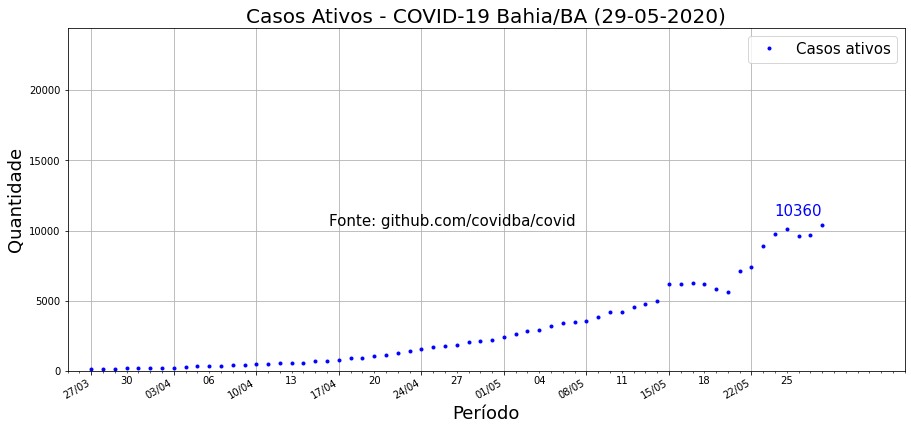

In [0]:
pd_ativos = pd.DataFrame.from_dict({"data":pd.date_range(start = df['data'].min(), end = df['data'].max()),
                                    "Casos Ativos": np.nan})
pd_ativos['data'] = pd.to_datetime(df['data'])
pd_ativos.columns = ['data', 'Casos ativos']

#set date as index
pd_ativos['Casos ativos'] = pd.Series(df['Casos ativos']).dropna()
pd_ativos.set_index('data', inplace=True)

fig, ax = plt.subplots(figsize=(15,7))
colors = ['b']
ls = ['.']
pd_ativos.plot(ax=ax, color=colors, style=ls, lw=3)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

ax.annotate(int(pd_ativos['Casos ativos'].max()), xy=(lista_data[ultimo_caso_valido_id], pd_ativos['Casos ativos'].max()), 
              xycoords='data', ha='right', fontsize=15, color='blue',
              xytext=(0, 10), textcoords='offset points')

ax.set_ylim(0, new_df['Expectativa'].max())
ax.set_xlim([lista_data.min()-timedelta(days=2), lista_data.max()])
ax.set_title("Casos Ativos - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)